In [17]:
from datasets import load_dataset
import matplotlib.pyplot as plt

In [18]:
dataset = load_dataset("multi_news")
print(f"Features: {dataset['train'].column_names}")

Features: ['document', 'summary']


In [19]:
dataset


DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
})

In [20]:
sample = dataset["train"][1]
print(f"""Document (excerpt of 2000 characters, total length: {len(sample["document"])}):""")
print(sample["document"][:2000])
print(f'\nSummary (length: {len(sample["summary"])}):')
print(sample["summary"])

Document (excerpt of 2000 characters, total length: 5353):
LOS ANGELES (AP) — In her first interview since the NBA banned her estranged husband, Shelly Sterling says she will fight to keep her share of the Los Angeles Clippers and plans one day to divorce Donald Sterling. 
 
 (Click Prev or Next to continue viewing images.) 
 
 ADVERTISEMENT (Click Prev or Next to continue viewing images.) 
 
 Los Angeles Clippers co-owner Shelly Sterling, below, watches the Clippers play the Oklahoma City Thunder along with her attorney, Pierce O'Donnell, in the first half of Game 3 of the Western Conference... (Associated Press) 
 
 Shelly Sterling spoke to Barbara Walters, and ABC News posted a short story with excerpts from the conversation Sunday. 
 
 NBA Commissioner Adam Silver has banned Donald Sterling for making racist comments and urged owners to force Sterling to sell the team. Silver added that no decisions had been made about the rest of Sterling's family. 
 
 According to ABC's story, Sh

In [21]:
from transformers import BartForConditionalGeneration, AutoTokenizer

model_ckpt = "sshleifer/distilbart-cnn-6-6"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BartForConditionalGeneration.from_pretrained(model_ckpt)

In [22]:
%%time
d_len = [len(tokenizer.encode(s)) for s in dataset["validation"]["document"]]
s_len = [len(tokenizer.encode(s)) for s in dataset["validation"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (2331 > 1024). Running this sequence through the model will result in indexing errors


CPU times: user 56.9 s, sys: 54.7 ms, total: 56.9 s
Wall time: 56.8 s


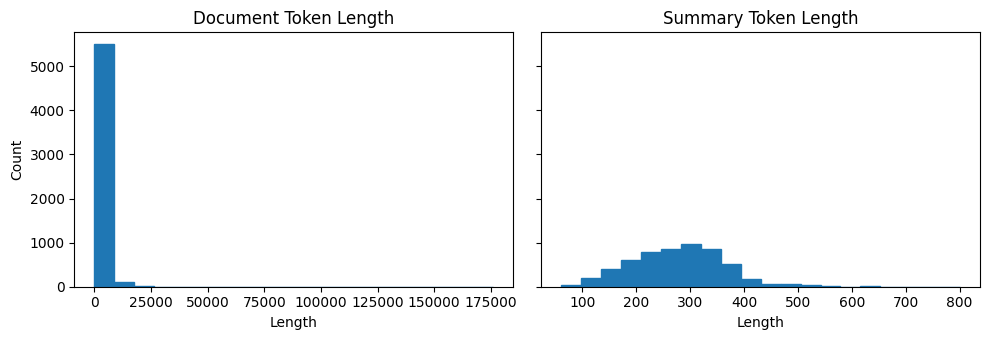

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Document Token Length")
axes[0].set_xlabel("Length")

axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [24]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["document"], max_length=1024, truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=256, truncation=True)
        
    return {"input_ids": input_encodings["input_ids"], 
           "attention_mask": input_encodings["attention_mask"], 
           "labels": target_encodings["input_ids"]}

dataset_tf = dataset.map(convert_examples_to_features, batched=True)

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3935: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [25]:
columns = ["input_ids", "labels", "attention_mask"]
dataset_tf.set_format(type="torch", columns=columns)

In [26]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [27]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir='bart-multi-news', num_train_epochs=1, warmup_steps=500, 
                                  per_device_train_batch_size=1, per_device_eval_batch_size=1, 
                                  weight_decay=0.01, logging_steps=10, push_to_hub=False, 
                                  evaluation_strategy='steps', eval_steps=500, save_steps=1e6, 
                                  gradient_accumulation_steps=16)

In [28]:
trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, 
                  data_collator=seq2seq_data_collator, 
                  train_dataset=dataset_tf["train"], 
                  eval_dataset=dataset_tf["validation"])

trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
500,2.625700,2.523416
1000,2.558600,2.431680


TrainOutput(global_step=1405, training_loss=2.636740890855891, metrics={'train_runtime': 11275.0921, 'train_samples_per_second': 3.989, 'train_steps_per_second': 0.125, 'total_flos': 4.829067747065856e+16, 'train_loss': 2.636740890855891, 'epoch': 1.0})

In [29]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
sample_text = dataset["test"][1]["document"]
reference = dataset["test"][1]["summary"]

input_ids = tokenizer(sample_text, max_length=1024, truncation=True, 
                   padding='max_length', return_tensors='pt').to(device)
summaries = model.generate(input_ids=input_ids['input_ids'], 
                           attention_mask=input_ids['attention_mask'], 
                           max_length=256)

decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                      clean_up_tokenization_spaces=True) 
                    for s in summaries]

print("Document:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(decoded_summaries[0])

Document:

 
 
 
 UPDATE: 4/19/2001 Read Richard Metzger: How I, a married, middle-aged man, became an accidental spokesperson for gay rights overnight on Boing Boing 
 
 It’s time to clarify a few details about the controversial “Hey Facebook what’s SO wrong with a pic of two men kissing?” story, as it now beginning to be reported in the mainstream media, and not always correctly. 
 
 First of all, with regards to the picture: 
 
 The photo which was used to illustrate my first post about the John Snow Kiss-In is a promotional still from the British soap opera “Eastenders.” It features one of the main characters from the show (Christian Clarke, played by the actor John Partridge- left) and someone else who I don’t know. I am not a regular viewer so I can’t say if the man on the right is an extra or an actual character. 
 
 This picture has itself caused scandal in the UK, as it was a gay kiss that was broadcast before the watershed, and as such led to a number of complaints to the BBC

In [31]:
from transformers import BartForConditionalGeneration, AutoTokenizer

model_ckpt = "sshleifer/distilbart-cnn-6-6"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BartForConditionalGeneration.from_pretrained(model_ckpt)

save_directory = "/kaggle/working/"  
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/vocab.json',
 '/kaggle/working/merges.txt',
 '/kaggle/working/added_tokens.json',
 '/kaggle/working/tokenizer.json')